In [1]:
import numpy as np
import watercolor_light
import matplotlib.pyplot as plt
import pygio

In [2]:
sps_library = watercolor_light.SPSLibraryData()
h = 0.6766
z_solar = 0.019

# H0: 100h km/s/Mpc.
# 1 Gyr = 1e9 years = 1e9 * 365.25 * 24 * 3600 seconds
# 1 Mpc = 3.08567758128e19 km
H0inv_in_Gyr = 1 / (100 * h * (1e9 * 365.25 * 24 * 3600 / 3.08567758128e19))

In [3]:
basepath = "/raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f"
gal_path = f"{basepath}/analysis/m000p-624.galaxyproperties"
gal_data = pygio.read_genericio(gal_path)

Read 95 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyproperties (279599 bytes) in 0.00591278s: 45.0966 MB/s [excluding header read]


In [4]:
galpart_path = f"{basepath}/analysis/m000p-624.galaxyparticles"
galpart_data = pygio.read_genericio(galpart_path)

galpart_path_sg = f"{basepath}/analysis/m000p-624.galaxyparticles.subgrid"
galpart_data_sg = pygio.read_genericio(galpart_path_sg)


def get_star_mask(mask):
    mask_bar = np.bitwise_and(mask, 4) > 0
    mask_dead = np.bitwise_and(mask, 128) > 0
    mask_star = np.bitwise_and(mask, 16) > 0
    mask_star &= ~mask_dead
    mask_star &= mask_bar
    return mask_star


mask_star = get_star_mask(galpart_data["mask"])
galstarpart_data = {k: d[mask_star] for k, d in galpart_data.items()}
s = np.argsort(galstarpart_data["id"])
galstarpart_data = {k: d[s] for k, d in galstarpart_data.items()}

mask_star = get_star_mask(galpart_data_sg["mask"])
galstarpart_data_sg = {k: d[mask_star] for k, d in galpart_data_sg.items()}
s = np.argsort(galstarpart_data_sg["id"])
galstarpart_data_sg = {k: d[s] for k, d in galstarpart_data_sg.items()}

assert np.all(galstarpart_data["id"] == galstarpart_data_sg["id"])
assert np.all(galstarpart_data["mask"] == galstarpart_data_sg["mask"])
for k, d in galstarpart_data_sg.items():
    galstarpart_data[k] = d

Read 16 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyparticles (11314757 bytes) in 0.365211s: 29.5462 MB/s [excluding header read]
Read 6 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyparticles.subgrid (758324 bytes) in 0.186381s: 3.88019 MB/s [excluding header read]


## Single Galaxy

In [5]:
target_idx = np.argmax(gal_data["gal_mass_star"])
target_tag = gal_data["gal_tag"][target_idx]
mask = galstarpart_data["gal_tag"] == target_tag

# relevant quantities
metallicities = galstarpart_data["zmet"][mask] / z_solar  # in Z/Zsun
ages = galstarpart_data["tage"][mask] * H0inv_in_Gyr  # in Gyr
masses = galstarpart_data["mass"][mask] / h  # in Msun

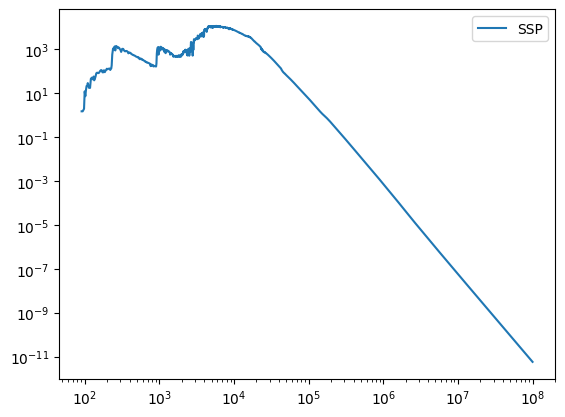

In [6]:
luminosity = watercolor_light.calc_galaxy_luminosity(
    ages, metallicities, masses, sps_library
)
flux = watercolor_light.luminosity_to_flux(luminosity)

fig, ax = plt.subplots()
ax.plot(sps_library.wave, flux, label="SSP")
ax.set(xscale="log", yscale="log")
# ax.set(xlim=(1e3, 1e6))
ax.legend()

### Convolve with bands

In [7]:
sdss = watercolor_light.filters["sdss"]
mags = watercolor_light.photometry_from_flux(sps_library.wave, flux, sdss)

In [39]:
filter = filters["LSST"]
photo = watercolor_light.photometry_from_spectra(
    1e-4 * sps_library.wave,
    1e-3 * total_luminosity,
    filter.bandpass_wavelengths,
    filter.bandpass_values,
)

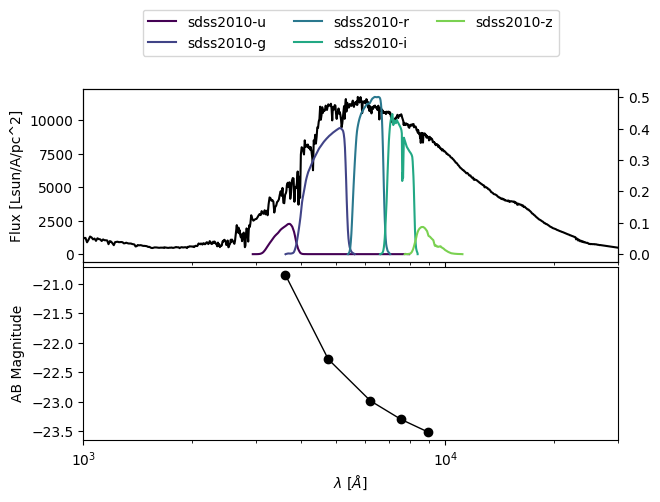

In [10]:
fig, axes = plt.subplots(2, 1)
ax = axes[0]
ax.plot(sps_library.wave, flux, label="SSP", color="black")
tax = ax.twinx()
for i, f in enumerate(sdss):
    color = plt.get_cmap("viridis")(i / len(sdss))
    tax.plot(f.wavelength, f.response, color=color, label=sdss.names[i])


axes[1].plot(
    sdss.effective_wavelengths,
    [mags[f] for f in sdss.names],
    color="black",
    marker="o",
    linewidth=1,
)

for ax in axes:
    ax.set(xscale="log", xlim=(1e3, 3e4))
for ax in axes[:-1]:
    ax.set_xticklabels([])
axes[0].set(ylabel="Flux [Lsun/A/pc^2]")
axes[1].set(xlabel=r"$\lambda$ [$\AA$]", ylabel="AB Magnitude")
tax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.5))
fig.tight_layout(pad=0)

In [11]:
print("G-R:", mags["sdss2010-g"] - mags["sdss2010-r"])

G-R: [0.70512792]


## Full Catalog Colors

In [17]:
mask = gal_data["gal_mass_star"] > 1e10
gal_tags = gal_data["gal_tag"][mask]

fluxes = []
for i, target_tag in enumerate(gal_tags):
    pmask = galstarpart_data["gal_tag"] == target_tag
    metallicities = galstarpart_data["zmet"][pmask] / z_solar
    ages = galstarpart_data["tage"][pmask]
    ages *= 1 * H0inv_in_Gyr
    masses = galstarpart_data["mass"][pmask] / h

    luminosity = watercolor_light.calc_galaxy_luminosity(
        ages, metallicities, masses, sps_library
    )
    flux = watercolor_light.luminosity_to_flux(luminosity)
    fluxes.append(flux)

gal_mags = watercolor_light.photometry_from_flux(
    sps_library.wave, np.array(fluxes), "sdss"
)

[None]

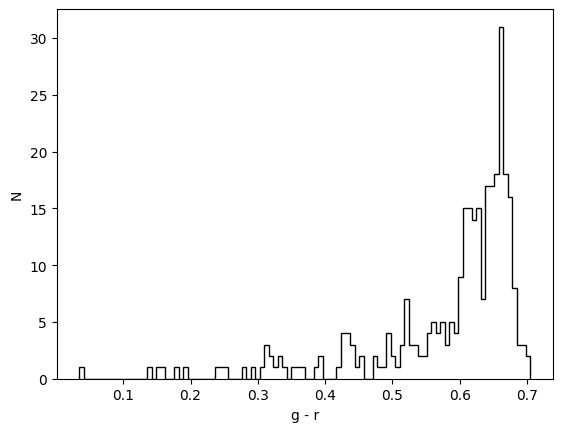

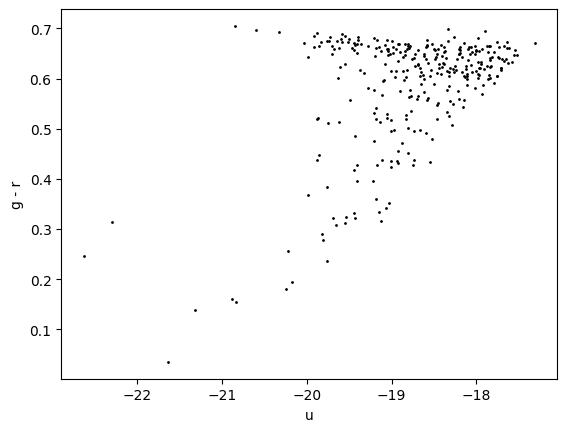

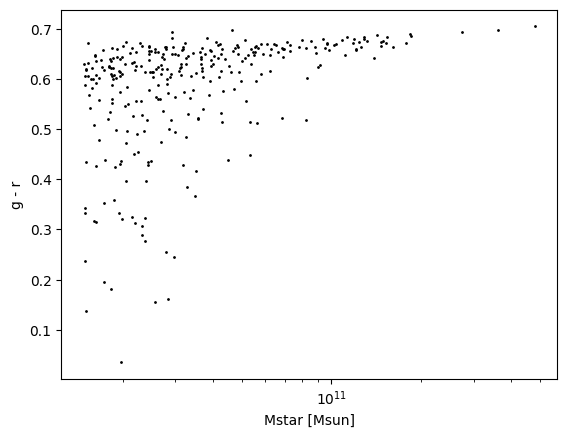

In [18]:
gminusr = gal_mags["sdss2010-g"] - gal_mags["sdss2010-r"]
rminusi = gal_mags["sdss2010-r"] - gal_mags["sdss2010-i"]

fig, ax = plt.subplots()
ax.hist(gminusr, bins=100, histtype="step", color="black")
ax.set(xlabel="g - r", ylabel="N")

fig, ax = plt.subplots()
ax.scatter(
    gal_mags["sdss2010-u"],
    gminusr,
    s=1,
    color="black",
)
ax.set(xlabel="u", ylabel="g - r")

fig, ax = plt.subplots()
ax.scatter(
    gal_data["gal_mass_star"][mask] / h,
    gminusr,
    s=1,
    color="black",
)
ax.set(xlabel="Mstar [Msun]", ylabel="g - r")
ax.set(xscale="log")